In [1]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from scipy.signal import find_peaks
import matplotlib.colors as mcolors

current_dir = '/home/marian/CIGAR_ANALYSIS/CIGAR/notebooks'

# Build the absolute path to ../functions
functions_path = os.path.abspath(os.path.join(current_dir, '../functions'))

# Add it to sys.path
sys.path.append(functions_path)

import parse_data 
import cigar as cig

from tqdm import tqdm


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
colors = ['royalblue', 'crimson', 'black', 'green', 'darkorange', 'brown', 'coral', 'indigo', 'magenta', 'blue']


##  Data reading

In [3]:
run         = f'Run26'
temperature = f'{8}deg'
pressure    = 6.5

run_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{run}"

nchannels       = 10
nevents_per_wvf = 500

samples_per_waveform = 752

event_header_bytes = 28
# event_header_bytes = 3036

# sample_binning = 1
sample_binning = 8e-9

nfiles = 30
start = 1

In [4]:
params = {'is_amplified':False,
          'amp_factors':{'CH1':269,
                         'CH2':267,
                         'CH3':258,
                         'CH4':275
                         },
            'pes':True,
            'temperature': temperature
          }

In [5]:
parse_data.checkWfs(run_dir, 
                    1, 10, 
                    nchannels, 
                    samples_per_waveform, 
                    event_header_bytes, 
                    print_headers = False
                    )

/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run26
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)


In [6]:

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_dir)[start:nfiles],desc="Reading .bin files", unit="file")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_dir, file)
        # print(file_path)
        df = parse_data.parse_wf_from_binary(file_path, channels = nchannels, 
                                             n_events = nevents_per_wvf,
                                             file_idx = i,
                                             event_header_bytes = event_header_bytes
                                             )  
        dataframes.append(df)

Reading .bin files: 100%|██████████| 29/29 [01:00<00:00,  2.08s/file]


In [7]:
# Merge all DataFrames into one
merged_df = pd.concat(dataframes, ignore_index=True)
merged_df.tail()

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,event,event_time,file_idx
10903995,0.000006,3.000907,2.820076,-369.438721,-513.619446,-409.401367,-398.009308,-351.508514,-540.606689,-408.391449,-527.467773,14499,278329529959,28
10903996,0.000006,2.510963,2.697464,-370.175995,-513.435364,-410.261597,-405.430969,-351.631226,-548.764221,-408.329926,-529.431335,14499,278329529959,28
10903997,0.000006,2.939664,2.636158,-369.745911,-515.338074,-410.691681,-412.791290,-351.079041,-558.271179,-408.268433,-535.997070,14499,278329529959,28
10903998,0.000006,3.062150,2.513546,-369.623047,-519.143555,-410.200134,-421.501007,-350.956329,-563.239319,-408.822052,-548.330811,14499,278329529959,28
10903999,0.000006,2.939664,2.881382,-369.192963,-526.509033,-410.200134,-431.682770,-350.342773,-564.588684,-409.314148,-564.591736,14499,278329529959,28


##  Data selection

In [8]:
# Filter for a specific event (change index as needed)
event_list  = merged_df['event'].unique()
nevents     = len(event_list)
print(f'Events per file = {len(event_list)/len(os.listdir(run_dir)[start:nfiles])}. Total nevents = {len(event_list)}')

Events per file = 500.0. Total nevents = 14500


In [9]:
if nchannels == 5:
    Amp_channels    = ['CH2', 'CH3', 'CH4', 'CH5'] # Amp
    noAmp_channels  = [] # noAmp

elif nchannels == 9:
    Amp_channels    = ['CH3', 'CH5', 'CH7', 'CH9'] # Amp
    noAmp_channels  = ['CH2', 'CH4', 'CH6', 'CH8'] # noAmp

elif nchannels == 10:
    Amp_channels    = ['CH4', 'CH6', 'CH8', 'CH10'] # Amp
    noAmp_channels  = ['CH3', 'CH5', 'CH7', 'CH9'] # noAmp

if params['is_amplified']:
    channels = Amp_channels
else:
    channels = noAmp_channels

all_channels    = noAmp_channels + Amp_channels


##  Noise filtering

In [10]:
# function to count number of peaks above threshold for one waveform
def count_high_peaks(group, channels_to_check, threshold=1000):
    peak_count = 0
    for ch in channels_to_check:
        peaks, _ = find_peaks(group[f'{ch}'].values, height=threshold)
        peak_count += len(peaks)
    return peak_count


In [11]:

# group by event (or event_time if that's more appropriate)
peak_counts      = merged_df.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels)

# keep only events with <= 5 peaks above 2000
valid_events     = peak_counts[peak_counts <= 4].index

# filter the original dataframe
filtered_df = merged_df[merged_df["event"].isin(valid_events)]

# update the number of valid events
event_list  = filtered_df['event'].unique()
nevents     = len(event_list)



/tmp/ipykernel_256715/343984057.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_counts      = merged_df.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels)


##  Baseline correction

In [12]:
# DEFINITION OF THE BASELINE WINDOW WIDTH HERE
window_width = 10


In [13]:
corrected_df   = filtered_df.copy()
for i, ch in enumerate(all_channels):

    voltage = filtered_df[f'{all_channels[i]}'].values

    v_matrix                    = voltage.reshape(nevents, -1)
    v_matrix_corrected, _, _    = cig.BaselineCorrection(v_matrix, window=window_width)

    corrected_df[f'{all_channels[i]}'] = v_matrix_corrected.flatten()


In [14]:
corrected_df.tail()

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,event,event_time,file_idx
10902491,0.000006,3.062150,29.733410,-0.086008,-12.576569,-0.270358,64.684949,-0.245428,134.243933,2.614352,557.216052,14497,278273641782,28
10902492,0.000006,3.245879,29.426880,0.036856,-10.735199,-0.639011,60.146069,0.552209,136.083960,1.691623,537.212040,14497,278273641782,28
10902493,0.000006,3.062150,29.242962,-0.024576,-6.070404,-0.884799,52.969800,0.613580,133.078558,1.014987,517.698925,14497,278273641782,28
10902494,0.000006,3.000907,29.181656,0.221182,-1.282806,-0.454684,43.646680,0.490869,124.430334,0.953464,496.774483,14497,278273641782,28
10902495,0.000006,3.184636,29.242962,-0.024576,3.075104,-0.393222,31.011487,0.306787,114.064703,1.014987,473.825093,14497,278273641782,28


##  Offline trigger

In [15]:
time_window_min = 1.8e-6 # [s]
time_window_max = 3e-6 # [s]

# time_window_min = 0.5e-6 # [s]
# if params['is_amplified']:
#     time_window_max = 2.5e-6 # [s]
# else:
#     time_window_max = 2e-6 # [s]


In [16]:
min_th = 1000 # [mV] Amp
# min_th = 0 # [mV]

signal_th = {'CH1':min_th,
             'CH2':min_th,
             'CH3':min_th,
             'CH4':min_th
             } # [mV]

if params['is_amplified'] == False:
    for ch in params['amp_factors'].keys():
        signal_th[ch] = signal_th[ch]/params['amp_factors'][ch]

signal_th['CHSum'] = sum(signal_th.values())


In [17]:
# AND artificial trigger
def all_channels_above_threshold(group, channels_to_check, time_col='time', tmin=0, tmax=10, threshold=800):
    """Return True if *all* channels exceed the threshold at least once within the time window."""
    sub = group[(group[time_col] >= tmin) & (group[time_col] <= tmax)]
    if sub.empty:
        return False

    # Check if each channel has any sample above threshold
    above_flags = [(sub[ch] > list(threshold.values())[ii]).any() for ii, ch in enumerate(channels_to_check)]

    # Only keep event if *all* channels exceed the threshold
    return all(above_flags)

In [18]:
# MAJORITY artificial trigger
def at_least_n_channels_above_threshold(
    group, channels_to_check, time_col='time', tmin=0, tmax=10, threshold=800, n_required=3
):
    """Return True if at least n_required channels exceed the threshold within the time window."""
    sub = group[(group[time_col] >= tmin) & (group[time_col] <= tmax)]
    if sub.empty:
        return False

    # Check if each channel has any sample above threshold
    above_flags = [(sub[ch] > threshold[ch]).any() for ch in channels_to_check]

    # Keep event if at least n_required channels exceed threshold
    return sum(above_flags) >= n_required


In [19]:
# # Apply per event
# valid_events_mask = corrected_df.groupby("event").apply(
#     all_channels_above_threshold,
#     channels_to_check=channels,
#     time_col="TIME",
#     tmin=time_window_min,
#     tmax=time_window_max,
#     threshold=signal_th
#     # ,n_required=3
# )

# # Extract valid events
# valid_response_events = valid_events_mask[valid_events_mask].index

# # Filter your dataframe
# final_df = corrected_df[corrected_df["event"].isin(valid_response_events)]

# # Update event list and count
# event_list = final_df["event"].unique()
# nevents = len(event_list)

In [20]:
final_df = corrected_df

# Update event list and count
event_list = final_df["event"].unique()
nevents = len(event_list)

##  Sum calculation

In [21]:
final_df      = cig.CreateWfSum(final_df, channels, params)
channels.append('CHSum')

['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9', 'CH10']


In [22]:
final_df.tail()


,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,CHSum,event,event_time,file_idx
10902491,0.000006,3.062150,29.733410,-0.086008,-12.576569,-0.270358,64.684949,-0.245428,134.243933,2.614352,557.216052,2.012558,14497,278273641782,28
10902492,0.000006,3.245879,29.426880,0.036856,-10.735199,-0.639011,60.146069,0.552209,136.083960,1.691623,537.212040,1.641678,14497,278273641782,28
10902493,0.000006,3.062150,29.242962,-0.024576,-6.070404,-0.884799,52.969800,0.613580,133.078558,1.014987,517.698925,0.719193,14497,278273641782,28
10902494,0.000006,3.000907,29.181656,0.221182,-1.282806,-0.454684,43.646680,0.490869,124.430334,0.953464,496.774483,1.210831,14497,278273641782,28
10902495,0.000006,3.184636,29.242962,-0.024576,3.075104,-0.393222,31.011487,0.306787,114.064703,1.014987,473.825093,0.903976,14497,278273641782,28


##  Signal spectrum

In [23]:
t_matrix = final_df['TIME'].values.reshape(nevents, -1)
time     = t_matrix[0]

In [24]:
time_window      = (time_window_min < time)  & (time < time_window_max)

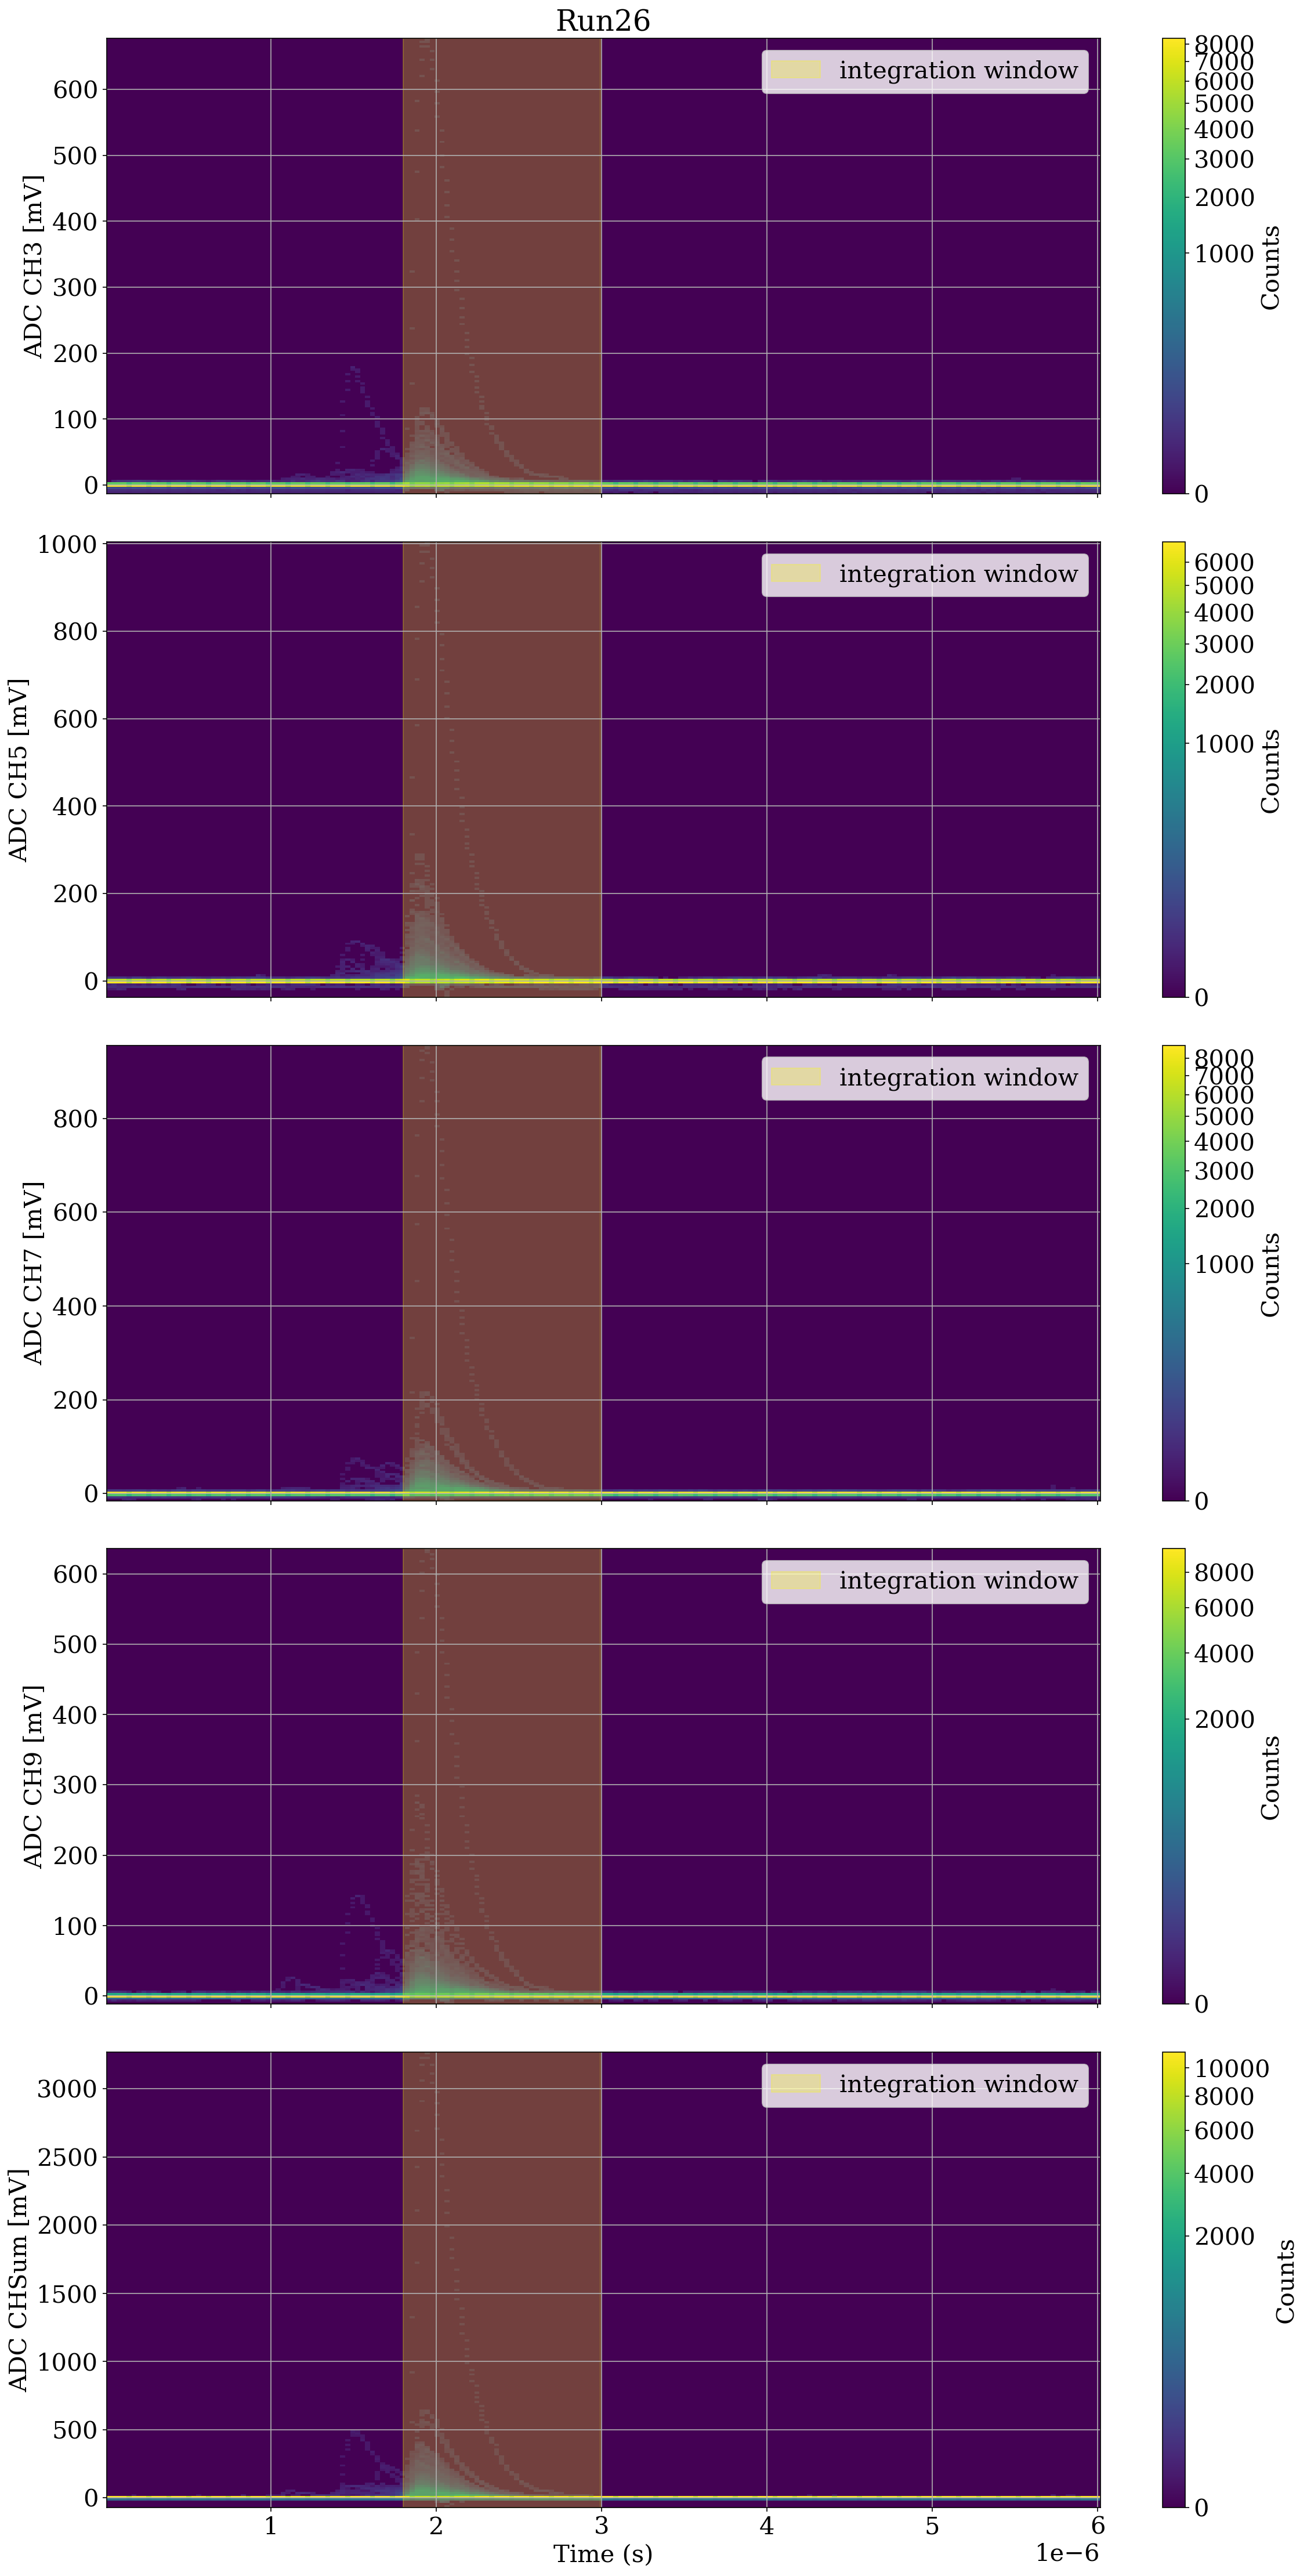

In [25]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


# Plot CHs
for i in range(len(channels)):

    if len(channels) > 1:
        ax = axs[i]

    voltage  = final_df[f'{channels[i]}'].values
    v_matrix = voltage.reshape(nevents, -1)
    # v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)
    v_matrix_corrected = v_matrix
    
    # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
    hb = ax.hist2d(t_matrix.flatten(), v_matrix_corrected.flatten(), bins=[200, 200], 
                   cmap='viridis', norm=mcolors.PowerNorm(gamma=0.3))

    fig.colorbar(hb[3], ax=ax, label="Counts")

    ax.fill_between(time[time_window], v_matrix_corrected.min(), v_matrix_corrected.max(), 
                    color = 'yellow', alpha = 0.25, label = 'integration window')

    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

##  Charge spectrum

Run26 is 78.09 mins long


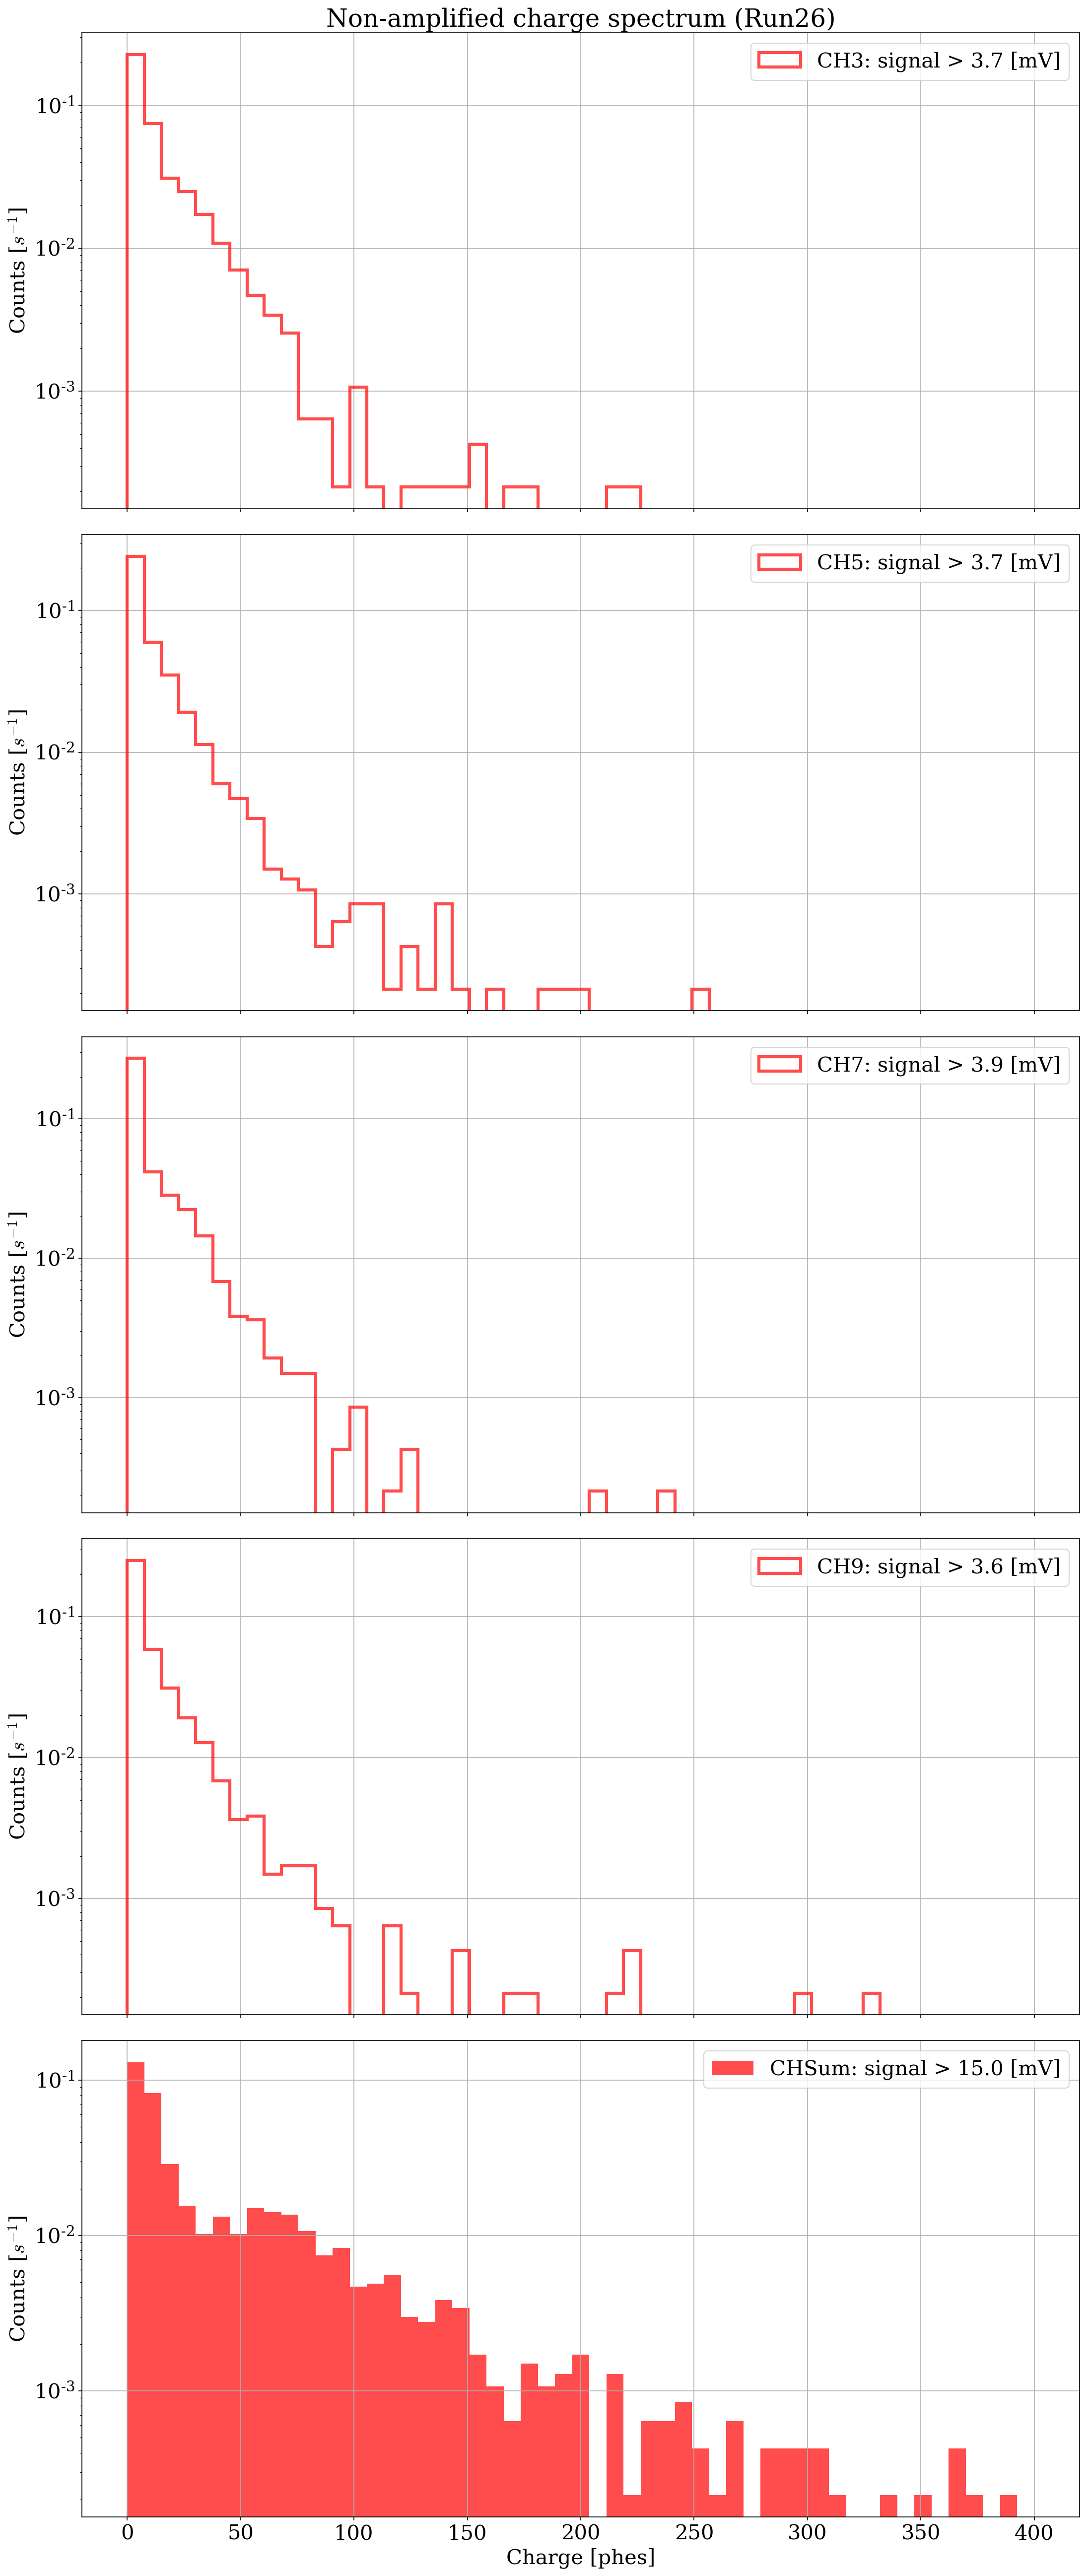

In [26]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(15, len(channels)*7), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(15, 7), dpi=150, sharex=True)

if len(channels) > 1:
    if params['is_amplified']:
        axs[0].set_title(f'Amplified charge spectrum ({run})')
    else:
        axs[0].set_title(f'Non-amplified charge spectrum ({run})')
else:
    if params['is_amplified']:
        ax.set_title(f'Amplified charge spectrum ({run})')
    else:
        ax.set_title(f'Non-amplified charge spectrum ({run})')

charge_Sum = 0


run_duration   = ((final_df.groupby('file_idx').max().event_time - final_df.groupby('file_idx').min().event_time)*8e-9).sum()
print(f"{run} is {run_duration/60:.2f} mins long")

# Plot CHs
for i, ch in enumerate(channels):

    if len(channels) > 1:
        ax = axs[i]
    
    voltage = final_df[f'{channels[i]}'].values

    v_matrix                    = voltage.reshape(nevents, -1)
    # v_matrix_corrected, _, _    = cig.BaselineCorrection(v_matrix, window=window_width)
    v_matrix_corrected = v_matrix

    charge = np.trapz(v_matrix_corrected[:, time_window]*1e-3,
                      x = time[time_window]
                      ,axis = 1)
    
    if params['pes']:
        if ch != 'CHSum':
            charge = cig.ChargeToPes(charge, channel=i+1, 
                                        temp = params['temperature'], amplified = params['is_amplified'], CHAmp=params['amp_factors'])
            charge_Sum = charge_Sum + charge
        else:
            charge = charge_Sum

    if ch == 'CHSum':
        hist_type = 'stepfilled'
    else:
        hist_type = 'step'
    events, bins, image = ax.hist(charge
                                ,bins = int(np.sqrt(len(charge))) 
                                ,range = (0, 400)
                                ,weights=np.ones_like(charge)/run_duration
                                ,density = False
                                ,histtype   =hist_type
                                ,color      = 'r'
                                ,ls         = '-'
                                ,lw         = 3
                                ,alpha      = 0.7
                                ,label = f'{ch}: signal > {signal_th[list(signal_th.keys())[i]]:.1f} [mV]'
                                )
    
    
    ax.set_ylabel(fr'Counts [$s^{{-1}}$]')
    ax.grid(True)
    ax.set_yscale('log')
    ax.legend()

if len(channels) > 1:
    if params['pes']:
        axs[-1].set_xlabel(r'Charge [phes]')
    else:
        axs[-1].set_xlabel(r'Charge [V $\cdot$ s]')
else:
    ax.set_xlabel(r'Charge [V $\cdot$ s]')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

In [27]:
voltage = final_df[f'{channels[3]}'].values

v_matrix                    = voltage.reshape(nevents, -1)
# v_matrix_corrected, _, _    = cig.BaselineCorrection(v_matrix, window=window_width)
v_matrix_corrected = v_matrix

charge = np.trapz(v_matrix_corrected[:, time_window]*1e-3,
                    x = time[time_window]
                    ,axis = 1)

d = cig.ChargeToPes(charge, channel=3+1, 
                                        temp = params['temperature'], amplified = params['is_amplified'], CHAmp=params['amp_factors'])

In [ ]:
save = False
if save:
    np.save(f'/home/marian/Downloads/{run}.npy', charge_Sum)